In [1245]:
import operator
import random
import requests
import time
import csv
import os
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
from scipy import stats
from ast import literal_eval
from matplotlib import pyplot as plt
from statsmodels.stats import diagnostic
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

# Data standard scaler
from sklearn.preprocessing import StandardScaler

# Random train-test split
from sklearn.model_selection import train_test_split

# Metrics and model selection
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_predict

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from scipy.stats import ttest_ind

#To visualize on of the RandomForest decision trees
#from sklearn import tree

#colors used when comparing genders
PURPLE = 'purple'
ORANGE = '#ffb82c'

#colors used when generic comparisons
BLUE = '#0173b2'
RED = '#d55e00'

#print(sns.color_palette("colorblind").as_hex())
#sns.color_palette("colorblind")

In [87]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1. Load the data
<a class="anchor" id="load"></a>

In [919]:
DATA_PATH = './data'
MOVIE_PATH = os.path.join(DATA_PATH, 'american_movies_cleaned.tsv')
CHAR_PATH = os.path.join(DATA_PATH, 'characters_cleaned.tsv')
THE_NUMBERS_PATH = os.path.join(DATA_PATH, 'the_numbers_cleaned_yearly_decayed.tsv')

### 1.1 Characters data
<a class="anchor" id="load_characters"></a>

In [874]:
df_chars=pd.read_csv(CHAR_PATH, sep="\t")
df_chars['m_release_date']=pd.to_datetime(df_chars['m_release_date'], errors = 'coerce')
df_chars.head(2)

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4


### 1.2 Movies data
<a class="anchor" id="load_movies"></a>

In [868]:
df_movies=pd.read_csv(MOVIE_PATH, sep='\t')
df_movies['m_release_date']=pd.to_datetime(df_movies['m_release_date'], errors = 'coerce')
df_movies.head(2)

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres,m_genre_PCA
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,['English Language'],United States of America,"['Thriller', 'Science Fiction', 'Horror', 'Adv...","Thriller, Crime Thriller, Action, Mystery"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,['English Language'],United States of America,"['Mystery', 'Biographical film', 'Drama', 'Cri...","Mystery, Horror, Children's/Family, Drama"


### 1.3 The numbers data

In [920]:
df_numbers=pd.read_csv(THE_NUMBERS_PATH, sep='\t').set_index('actor_name')
df_numbers.head(2)

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
actor_name,,,,,,,,,,,,,,,,,,,,,
Jane Fonda,328.691575,626.104012,566.522337,512.610609,463.829260,419.690070,588.918645,532.875627,482.165806,436.281663,...,155.940906,194.223037,175.740272,159.016374,143.883965,326.078494,295.048022,266.970491,241.564890,218.576951
Clint Eastwood,577.700345,522.724888,758.511094,998.420210,1457.867491,1591.382644,1715.512267,1552.259691,1643.591069,1580.145973,...,763.566226,690.903293,625.155152,565.663773,511.833748,698.854629,632.349818,572.173776,637.248452,576.606244


# 2.1 Df chars cleaning

In [875]:
df_chars.drop_duplicates(['wikipedia_m_ID', 'actor_name'], keep='first', inplace=True)

In [882]:
df_chars = df_chars[df_chars.duplicated('wikipedia_m_ID', keep=False)]

In [965]:
df_chars = df_chars.merge(df_movies[['wikipedia_m_ID']], how='inner', on='wikipedia_m_ID')

# 2.2 Compute number of actors per movie

In [966]:
#compute number of actors per movie
nb_actors_per_movie = df_chars['wikipedia_m_ID'].value_counts()
nb_actors_per_movie.sum()

234272

In [967]:
#get unique IDs of movies
list_unique_id_movies_of_actors = list(df_chars['wikipedia_m_ID'].unique())

In [968]:
df_movies['nb_actors'] = df_movies['wikipedia_m_ID'].apply(lambda x: nb_actors_per_movie[x] if x in list_unique_id_movies_of_actors else 0)

In [969]:
#movies with just 1 actor are dropped (as the interest is for coacting)
df_movies = df_movies[df_movies['nb_actors'] > 0]

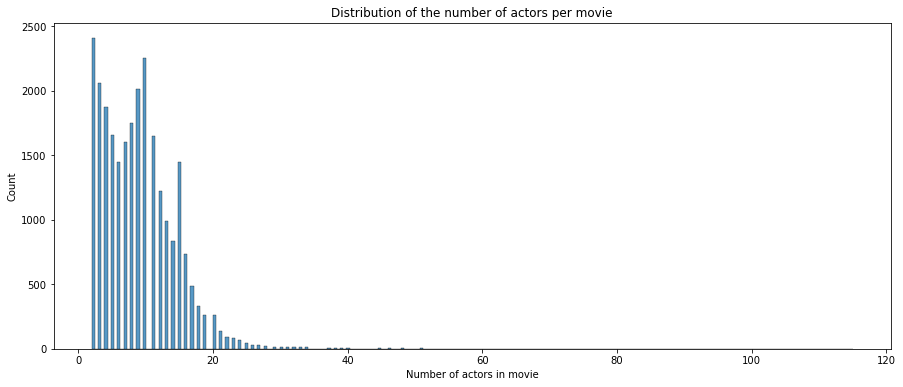

In average, there is 9.03 actors per movie among the american movies dataset with more than two actors.
There are 25938 unique movies which have a known list of actors greater than 2.


In [970]:
#nb actors per movie
plt.figure(figsize=(15, 6))
sns.histplot(data=df_movies, x='nb_actors')
plt.title("Distribution of the number of actors per movie")
plt.ylabel("Count")
plt.xlabel("Number of actors in movie")
plt.show()
avg_nb_actors_per_movie = df_movies['nb_actors'].mean()
nb_unique_movies_with_actors = df_movies['wikipedia_m_ID'].nunique()
print("In average, there is {:.2f} actors per movie among the american movies dataset with more than two actors.".format(avg_nb_actors_per_movie))
print("There are {} unique movies which have a known list of actors greater than 2.".format(nb_unique_movies_with_actors))

# 2.3 Number of movies of actor when releasing movie

In [988]:
#merge: if known score, column of score is = to score, otherwise = 0
df_chars_numbers = df_chars.merge(df_numbers, left_on='actor_name', right_index=True, how='left').copy()
df_chars_numbers.head()

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,...,51.575733,46.667653,42.226639,38.208243,34.572248,31.282263,28.305362,25.611751,23.174471,20.969128
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,...,657.985608,860.979352,779.046334,1053.522550,1032.949430,934.651296,845.707465,765.227759,692.406710,626.515500
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,...,639.378954,651.576574,835.259518,755.774065,979.343060,1148.435483,1331.317686,1204.626058,1285.877630,1163.510195
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea Duvall,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [991]:
nb_movies_per_actor = df_chars_numbers.groupby('actor_name')['wikipedia_m_ID'].count()

In [992]:
def get_nb_movies_each_year(row):
    release_year = row['m_release_date'].year
    actor_name = row['actor_name']
    movies = map_nb_movies_per_year.loc[(map_nb_movies_per_year['m_release_date'].dt.year < release_year) & (map_nb_movies_per_year['actor_name'] == actor_name)]
    nb_movies = movies.shape[0]
    return nb_movies

In [993]:
df_chars_numbers['nb_movies_at_release_year'] = df_chars_numbers.apply(lambda row: get_nb_movies_each_year(row), axis=1)

# 2.4 Compute scores per actor at movie time

In [995]:
df_chars_numbers = df_chars_numbers[df_chars_numbers['m_release_date'].dt.year > 1980].copy()

In [997]:
df_chars_numbers['wikipedia_m_ID'].count()

155179

In [939]:
def get_movie_actor_score(row):
    release_date = row['m_release_date'].year
    if row[str(release_date-1)] > 0 :
        return row[str(release_date-1)]
    else:
        return 0

In [998]:
df_chars_numbers['movie_actor_score'] = df_chars_numbers.apply(lambda row: get_movie_actor_score(row), axis=1)

# 2.5 Compurte scores per movie

In [999]:
df_chars_numbers['actor_name'].nunique()

53669

In [1009]:
df_chars_numbers.head(2)

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,2015,2016,2017,2018,2019,2020,2021,2022,nb_movies_at_release_year,movie_actor_score
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,...,42.226639,38.208243,34.572248,31.282263,28.305362,25.611751,23.174471,20.969128,8,189.246665


In [1083]:
columns = ['wikipedia_m_ID', 'actor_name', 'nb_movies_at_release_year', 'movie_actor_score']
df_temp = df_chars_numbers.copy()
df_temp['nb_movies_at_release_year'] = df_temp['nb_movies_at_release_year'].astype(str)
df_temp['movie_actor_score'] = df_temp['movie_actor_score'].astype(str)
df_grouped = df_temp[columns].groupby('wikipedia_m_ID').agg({'actor_name':'$l$'.join, 'nb_movies_at_release_year':'$l$'.join, 'movie_actor_score':'$l$'.join})

In [1084]:
df_grouped

,actor_name,nb_movies_at_release_year,movie_actor_score
wikipedia_m_ID,,,
3217,Ted Raimi$l$Ivan Raimi$l$Bruce Campbell$l$Brid...,0$l$0$l$8$l$11$l$0$l$0$l$0$l$0$l$0$l$0$l$0,0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$...
3746,William Sanderson$l$Harrison Ford$l$Rutger Hau...,0$l$1$l$1$l$1$l$1$l$0$l$0$l$0$l$0$l$2$l$0$l$0$...,0.0$l$806.6699240571911$l$0.0$l$0.0$l$0.0$l$0....
3947,Dick Green$l$Isabella Rossellini$l$Kyle Maclac...,0$l$0$l$0$l$5$l$0$l$0$l$0$l$0$l$0$l$0$l$0$l$0$...,0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$...
4231,Kristy Swanson$l$Donald Sutherland$l$Paul Reub...,0$l$18$l$8$l$16$l$1$l$0$l$0$l$0$l$0$l$0$l$0$l$...,0.0$l$0.0$l$147.5916228316312$l$100.2165340214...
4560,Tommy Flanagan$l$Sean Lawlor$l$Sophie Marceau$...,0$l$0$l$0$l$0$l$18$l$0$l$0$l$0$l$0$l$0$l$3$l$0...,0.0$l$0.0$l$0.0$l$0.0$l$2014.0407164110889$l$0...
...,...,...,...
36619262,Leonardo Nam$l$Ryan O'Nan$l$Gillian Jacobs$l$J...,0$l$0$l$5$l$0$l$0$l$0$l$0$l$1$l$0$l$0$l$0,0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$...
36724042,Krasimir Simeonov$l$John Barrowman$l$Jenny Mcs...,0$l$0$l$0$l$0$l$0$l$0$l$0$l$0$l$0,0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$...
36956792,Geraldine Brophy$l$Bruce Allpress$l$Edward Cam...,0$l$0$l$0$l$12$l$0$l$0$l$0$l$0$l$0$l$0$l$0$l$0...,0.0$l$0.0$l$0.0$l$62.65663730093336$l$0.0$l$0....


In [1085]:
def get_function_of_score(list_scores, function):
    list_split = list_scores.split('$l$')
    list_split = [float(x) for x in list_split]
    if function == 'max':
        return max(list_split)
    if function == 'min':
        return min(list_split)
    if function == 'mean':
        return np.mean(list_split)
    if function == 'median':
        return np.median(list_split)
    if function == 'nb_famous_actors':
        return np.count_nonzero(list_split)
    if function == 'nb_actors':
        return len(list_split)
    if function == 'prop_famous_actors':
        return (np.count_nonzero(list_split))/float(len(list_split))

In [1086]:
list_function_score = ['nb_actors', 'max', 'min', 'mean', 'median', 'nb_famous_actors', 'prop_famous_actors']
for f in list_function_score:
    df_grouped[f] = df_grouped['movie_actor_score'].apply(lambda x: get_function_of_score(x, f))

In [1087]:
df_grouped.head(2)

,actor_name,nb_movies_at_release_year,movie_actor_score,nb_actors,max,min,mean,median,nb_famous_actors,prop_famous_actors
wikipedia_m_ID,,,,,,,,,,
3217,Ted Raimi$l$Ivan Raimi$l$Bruce Campbell$l$Brid...,0$l$0$l$8$l$11$l$0$l$0$l$0$l$0$l$0$l$0$l$0,0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$...,11,0.000000,0.0,0.000000,0.0,0,0.000000
3746,William Sanderson$l$Harrison Ford$l$Rutger Hau...,0$l$1$l$1$l$1$l$1$l$0$l$0$l$0$l$0$l$2$l$0$l$0$...,0.0$l$806.6699240571911$l$0.0$l$0.0$l$0.0$l$0....,15,806.669924,0.0,53.777995,0.0,1,0.066667


# 2.6 Merge score with actors

In [1088]:
df_chars_merged = df_chars_numbers.merge(df_grouped[list_function_score], left_on='wikipedia_m_ID', right_index=True, how='left').copy()
df_chars_merged.head(3)

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,2022,nb_movies_at_release_year,movie_actor_score,nb_actors,max,min,mean,median,nb_famous_actors,prop_famous_actors
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,NaN,0,0.000000,17,810.280996,0.0,73.211437,0.0,5,0.294118
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,...,20.969128,8,189.246665,17,810.280996,0.0,73.211437,0.0,5,0.294118
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,...,626.515500,14,810.280996,17,810.280996,0.0,73.211437,0.0,5,0.294118


# 2.7 Min year and min year score of actors

In [1052]:
def get_min_year(row):
    for x in df_numbers.columns[:-2]:
        if row[x] >0:
            return int(x)

In [1053]:
def get_min_year_score(row):
    for x in df_numbers.columns[:-2]:
        if row[x] >0:
            return float(row[x])

In [1089]:
#df_chars_numbers['min_year'] 
df_chars_merged['min_year'] = df_chars_merged.apply(lambda row: get_min_year(row), axis=1)
df_chars_merged['min_year_score'] = df_chars_merged.apply(lambda row: get_min_year_score(row), axis=1)

In [1090]:
df_chars_merged['min_year'] = df_chars_merged['min_year'].fillna(0)
df_chars_merged['min_year_score'] = df_chars_merged['min_year_score'].fillna(0)
df_chars_merged.head(3)

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,movie_actor_score,nb_actors,max,min,mean,median,nb_famous_actors,prop_famous_actors,min_year,min_year_score
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,0.000000,17,810.280996,0.0,73.211437,0.0,5,0.294118,0.0,0.000000
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,...,189.246665,17,810.280996,0.0,73.211437,0.0,5,0.294118,2000.0,189.246665
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,...,810.280996,17,810.280996,0.0,73.211437,0.0,5,0.294118,1991.0,258.969120


# 2.8 Number of actors revealed per movie

In [1099]:
df_chars_merged['is_revealed'] = df_chars_merged.apply(lambda row: row['min_year'] == row['m_release_date'].year, axis=1).astype(int)
df_chars_merged['already_revealed'] = df_chars_merged.apply(lambda row: row['min_year'] < row['m_release_date'].year and row['min_year']!=0.0, axis=1).astype(int)
df_chars_merged.head()

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,max,min,mean,median,nb_famous_actors,prop_famous_actors,min_year,min_year_score,is_revealed,already_revealed
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,810.280996,0.0,73.211437,0.0,5,0.294118,0.0,0.000000,0,0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,...,810.280996,0.0,73.211437,0.0,5,0.294118,2000.0,189.246665,0,1
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,...,810.280996,0.0,73.211437,0.0,5,0.294118,1991.0,258.969120,0,1
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,...,810.280996,0.0,73.211437,0.0,5,0.294118,2000.0,63.082222,0,1
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea Duvall,23.0,...,810.280996,0.0,73.211437,0.0,5,0.294118,0.0,0.000000,0,0


In [1101]:
df_chars_merged.drop_duplicates('wikipedia_m_ID', keep='first').groupby(['is_revealed']).mean()

,wikipedia_m_ID,actor_height,actor_age,1980,1981,1982,1983,1984,1985,1986,...,nb_actors,max,min,mean,median,nb_famous_actors,prop_famous_actors,min_year,min_year_score,already_revealed
is_revealed,,,,,,,,,,,,,,,,,,,,,
0,1.165941e+07,1.820167,39.312757,11.370674,19.019498,29.910898,48.770361,59.877079,77.469506,93.449640,...,10.614364,303.997515,0.543598,39.859666,3.961674,1.354854,0.121393,471.967614,47.421568,0.160396
1,7.440480e+06,1.747861,33.195021,0.000000,2.669645,7.294134,13.714542,19.320694,37.944848,49.958795,...,12.681633,449.104286,0.000000,53.842650,2.227491,1.816327,0.138804,1997.379592,197.092982,0.000000


There are 18.12% of movies where at least one actor was revealed.


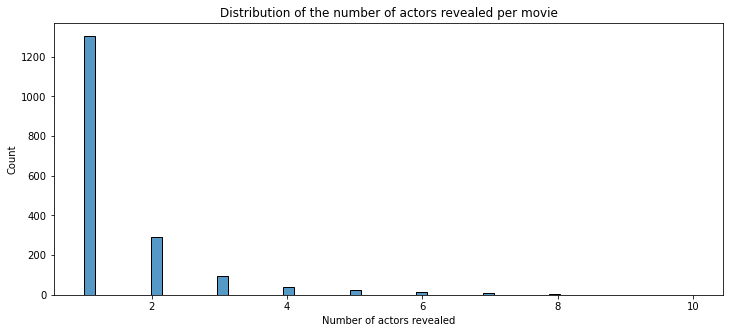

In [1149]:
df_movies_reveal = df_chars_merged.groupby('wikipedia_m_ID')['is_revealed'].sum().reset_index().sort_values('is_revealed')
prop_movies_with_reveal = df_movies_reveal['is_revealed'].sum()/df_movies_reveal['is_revealed'].count()
print("There are {:.2f}% of movies where at least one actor was revealed.".format(prop_movies_with_reveal*100))

df_movies_reveal_only = df_movies_reveal[df_movies_reveal['is_revealed'] > 0]

plt.figure(figsize=(12, 5))
sns.histplot(data=df_movies_reveal_only, x = 'is_revealed')
plt.title("Distribution of the number of actors revealed per movie")
plt.ylabel("Count")
plt.xlabel("Number of actors revealed")
plt.show()

In [1151]:
df_movies_reveal.rename({'is_revealed':'nb_revealed'}, axis=1, inplace=True)

In [1154]:
df_chars_merged = df_chars_merged.merge(df_movies_reveal, left_on='wikipedia_m_ID', right_on='wikipedia_m_ID', how='left').copy()

# 3.1 Correlation

In [1302]:
df_chars_merged['is_revealed'].value_counts()

0    152538
1      2641
Name: is_revealed, dtype: int64

In [1299]:
df_all_binary = df_chars_merged.drop_duplicates(subset=['wikipedia_m_ID', 'is_revealed'], keep='first')

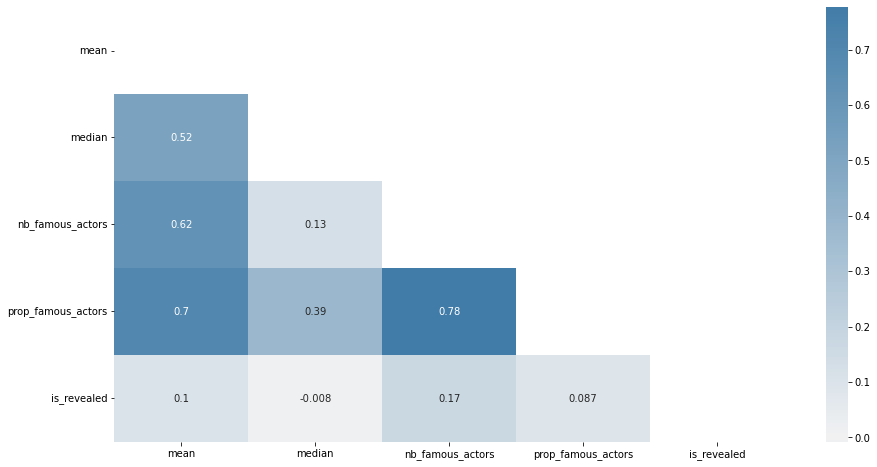

In [1308]:
columns = ['wikipedia_m_ID', 'actor_name', 'mean', 'median', 'nb_famous_actors', 'prop_famous_actors', 'is_revealed']
dataset = df_all_binary[columns].groupby(['wikipedia_m_ID', 'actor_name']).mean()

# Heatmap of the correlation between the attributes
corr = dataset.corr()
mask = np.triu(np.ones_like(corr, dtype='bool'))

plt.figure(figsize=(15, 8))
cmap = sns.diverging_palette(240,240, as_cmap=True)
sns.heatmap(data=corr, cmap=cmap, center=0, mask=mask, annot=True)
plt.show()

In [1309]:
df_all_binary['is_revealed'].value_counts()

0    14572
1     1781
Name: is_revealed, dtype: int64

In [1310]:
df_all_binary.groupby('is_revealed').mean()

,wikipedia_m_ID,actor_height,actor_age,1980,1981,1982,1983,1984,1985,1986,...,max,min,mean,median,nb_famous_actors,prop_famous_actors,min_year,min_year_score,already_revealed,nb_revealed
is_revealed,,,,,,,,,,,,,,,,,,,,,
0,1.158848e+07,1.818345,39.303136,11.455891,19.089252,30.243932,49.925148,61.624181,79.497394,96.156540,...,306.437205,0.534459,40.094763,3.932517,1.362613,0.121686,482.635671,48.662087,0.164699,0.181238
1,8.082075e+06,1.749739,32.287112,0.000000,3.925978,9.225092,16.985851,24.666134,35.826739,45.880532,...,576.323516,0.000000,64.631206,2.990962,2.400898,0.163527,1998.911847,194.039489,0.000000,1.482875


# 3.2 Training

In [1311]:
X = dataset.drop('is_revealed', axis=1)
y = dataset['is_revealed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Dictionary to store the results
logistic_regression_results = dict()

# Build and fit classifier to training data
clf = LogisticRegression(solver='liblinear', max_iter=10000, C=2, class_weight='balanced')
clf.fit(X_train, y_train)

# Training set accuracy
y_pred = clf.predict(X_train)
acc_tr = accuracy_score(y_pred, y_train) * 100
print("Accuracy on the training data: {:.2f}%".format(acc_tr))

Accuracy on the training data: 71.85%


In [1312]:
# Predict the binary output with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict")
# Compute the False Positive Rate and True Positive Rate
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.76      0.93      0.84      3576
         1.0       0.53      0.21      0.30      1330

    accuracy                           0.73      4906
   macro avg       0.64      0.57      0.57      4906
weighted avg       0.70      0.73      0.69      4906



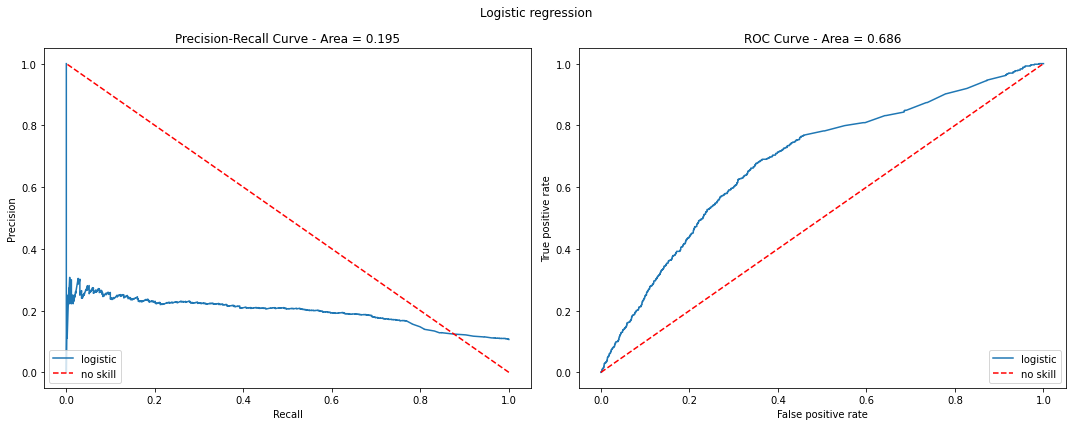

In [1313]:
# Predict the probabilities with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict_proba")

#Compute the precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred[:, 1])

#Compute the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])

# Compute the area under the P-R curve and ROC curve
pr_score = auc(recall, precision)
roc_score = auc(fpr, tpr)

# Plot P-R curve and ROC curve
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

ax = axs[0]
ax.plot(recall, precision, label='logistic')
ax.plot([1, 0], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve - Area = {:.3f}".format(pr_score))
ax.legend(loc = 'lower left')

ax = axs[1]
ax.plot(fpr, tpr, label='logistic')
ax.plot([0, 1], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC Curve - Area = {:.3f}".format(roc_score))
ax.legend(loc = 'lower right')

fig.suptitle('Logistic regression')
fig.tight_layout()
plt.show()

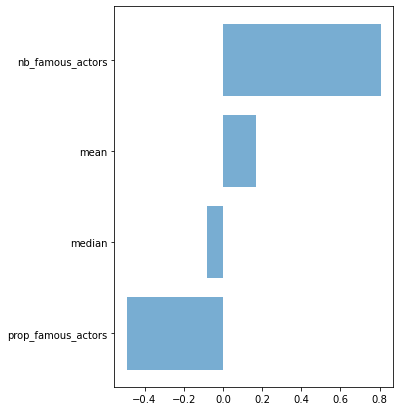

In [1314]:
# Weight of each column in logistic regression
tmp = []
for name, value in zip(dataset.columns, clf.coef_[0]):
    tmp.append({"name": name, "value": value})

features_coef = pd.DataFrame(tmp).sort_values("value")

plt.subplots(figsize=(5,7))
plt.barh(features_coef.name, features_coef.value, alpha=0.6)
plt.show()

# 4.1 Only unknown actors

In [1222]:
df_unknown = df_chars_merged[df_chars_merged['nb_famous_actors'] == 0]

In [1235]:
df_chars_merged['is_revealed'].value_counts()

0    152538
1      2641
Name: is_revealed, dtype: int64

In [1224]:
df_unknown['is_revealed'].value_counts()

0    52425
1      465
Name: is_revealed, dtype: int64

# 5.1 Movies with at least one famous actor

In [1316]:
df_one_known = df_chars_merged[df_chars_merged['nb_famous_actors'] > 0].drop_duplicates(subset=['wikipedia_m_ID', 'is_revealed'], keep='first')

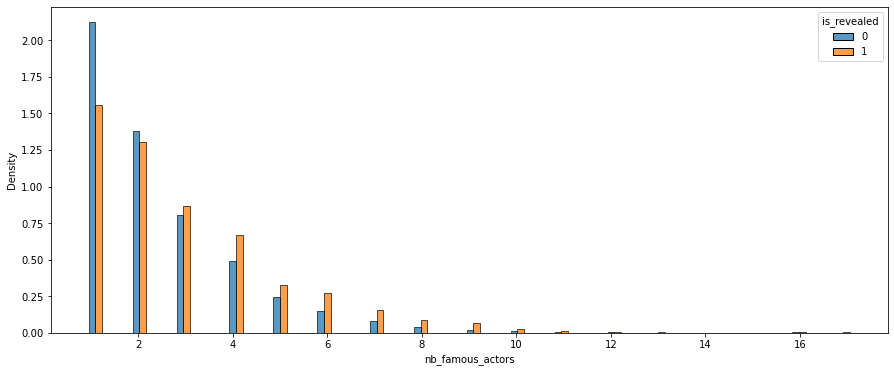

In [1317]:
plt.figure(figsize=(15, 6))
sns.histplot(data=df_one_known, x='nb_famous_actors', hue='is_revealed', stat = 'density', common_norm=False, shrink = 1.5, multiple="dodge")
plt.show()

In [1322]:
ttest_ind(df_one_known[df_one_known['is_revealed'] == 0]['nb_famous_actors'], df_one_known[df_one_known['is_revealed'] == 1]['nb_famous_actors'])

Ttest_indResult(statistic=-10.711150090074558, pvalue=1.2692929681353788e-26)

In [1318]:
df_one_known.groupby('is_revealed').mean()

,wikipedia_m_ID,actor_height,actor_age,1980,1981,1982,1983,1984,1985,1986,...,max,min,mean,median,nb_famous_actors,prop_famous_actors,min_year,min_year_score,already_revealed,nb_revealed
is_revealed,,,,,,,,,,,,,,,,,,,,,
0,1.042618e+07,1.849235,39.729109,13.424132,22.368983,35.360927,57.874421,71.037978,91.272917,109.892815,...,538.909359,0.939914,70.511814,6.915839,2.396331,0.214000,732.343833,75.336522,0.289645,0.262612
1,8.140354e+06,1.751599,32.699296,0.000000,1.883154,3.898291,7.467528,12.678651,19.814741,26.619542,...,707.396404,0.000000,79.330240,3.671195,2.946933,0.200717,2000.290145,190.017774,0.000000,1.499655


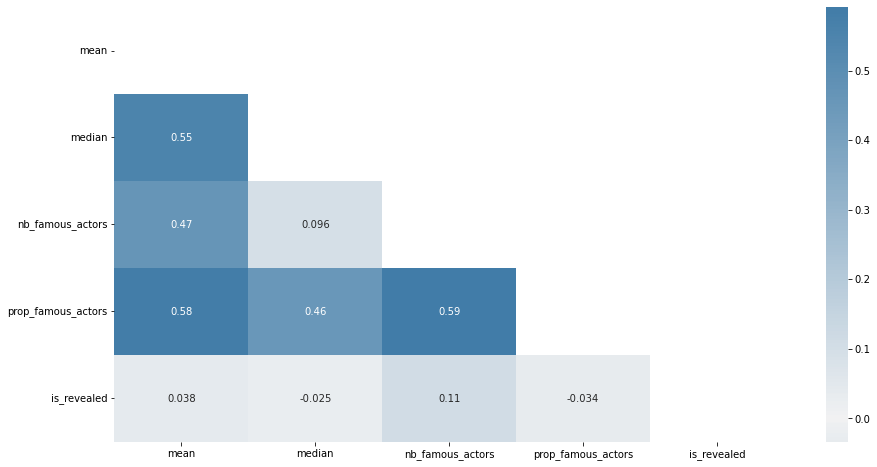

In [1323]:
columns = ['wikipedia_m_ID', 'actor_name', 'mean', 'median', 'nb_famous_actors', 'prop_famous_actors', 'is_revealed']
dataset = df_one_known[columns].groupby(['wikipedia_m_ID', 'actor_name']).mean()

# Heatmap of the correlation between the attributes
corr = dataset.corr()
mask = np.triu(np.ones_like(corr, dtype='bool'))

plt.figure(figsize=(15, 8))
cmap = sns.diverging_palette(240,240, as_cmap=True)
sns.heatmap(data=corr, cmap=cmap, center=0, mask=mask, annot=True)
plt.show()

In [1334]:
X = dataset.drop('is_revealed', axis=1)
y = dataset['is_revealed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Dictionary to store the results
logistic_regression_results = dict()

# Build and fit classifier to training data
clf = LogisticRegression(max_iter=100000, C=0.2, class_weight='balanced')
clf.fit(X_train, y_train)

# Training set accuracy
y_pred = clf.predict(X_train)
acc_tr = accuracy_score(y_pred, y_train) * 100
print("Accuracy on the training data: {:.2f}%".format(acc_tr))

Accuracy on the training data: 62.17%


In [1329]:
# Predict the binary output with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict")
# Compute the False Positive Rate and True Positive Rate
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.69      0.87      0.77      1975
         1.0       0.42      0.20      0.27       947

    accuracy                           0.65      2922
   macro avg       0.56      0.53      0.52      2922
weighted avg       0.60      0.65      0.61      2922



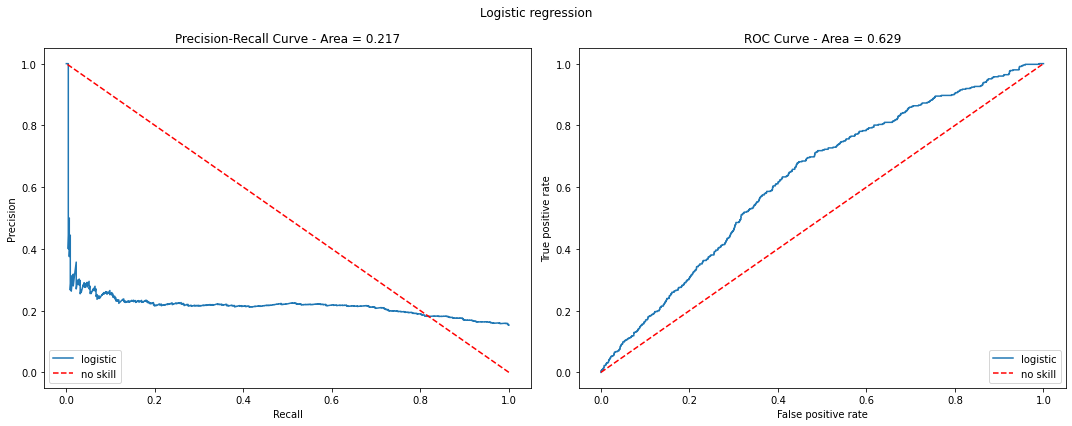

In [1282]:
# Predict the probabilities with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict_proba")

#Compute the precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred[:, 1])

#Compute the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])

# Compute the area under the P-R curve and ROC curve
pr_score = auc(recall, precision)
roc_score = auc(fpr, tpr)

# Plot P-R curve and ROC curve
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

ax = axs[0]
ax.plot(recall, precision, label='logistic')
ax.plot([1, 0], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve - Area = {:.3f}".format(pr_score))
ax.legend(loc = 'lower left')

ax = axs[1]
ax.plot(fpr, tpr, label='logistic')
ax.plot([0, 1], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC Curve - Area = {:.3f}".format(roc_score))
ax.legend(loc = 'lower right')

fig.suptitle('Logistic regression')
fig.tight_layout()
plt.show()

# 6.1 Movies with at least one famous actor and no same movie

In [1365]:
df_one_known_unique = df_chars_merged[df_chars_merged['nb_famous_actors'] > 0].drop_duplicates(subset=['wikipedia_m_ID', 'is_revealed'], keep='first').copy()
df_one_known_unique = df_one_known_unique.sort_values(['wikipedia_m_ID', 'is_revealed'])
df_one_known_unique = df_one_known_unique.drop_duplicates(subset=['wikipedia_m_ID'], keep='last').copy()

In [1368]:
df_one_known_unique['is_revealed'].value_counts()

0    6835
1    1451
Name: is_revealed, dtype: int64

In [1369]:
df_one_known_unique.groupby('is_revealed').mean()

,wikipedia_m_ID,actor_height,actor_age,1980,1981,1982,1983,1984,1985,1986,...,max,min,mean,median,nb_famous_actors,prop_famous_actors,min_year,min_year_score,already_revealed,nb_revealed
is_revealed,,,,,,,,,,,,,,,,,,,,,
0,1.091143e+07,1.868442,39.930299,13.057986,21.601932,34.911980,56.328618,68.425842,87.561573,104.973717,...,503.141297,1.139449,68.639753,7.604644,2.279444,0.216820,710.935040,72.398465,0.279444,0.000000
1,8.140354e+06,1.751599,32.699296,0.000000,1.883154,3.898291,7.467528,12.678651,19.814741,26.619542,...,707.396404,0.000000,79.330240,3.671195,2.946933,0.200717,2000.290145,190.017774,0.000000,1.499655


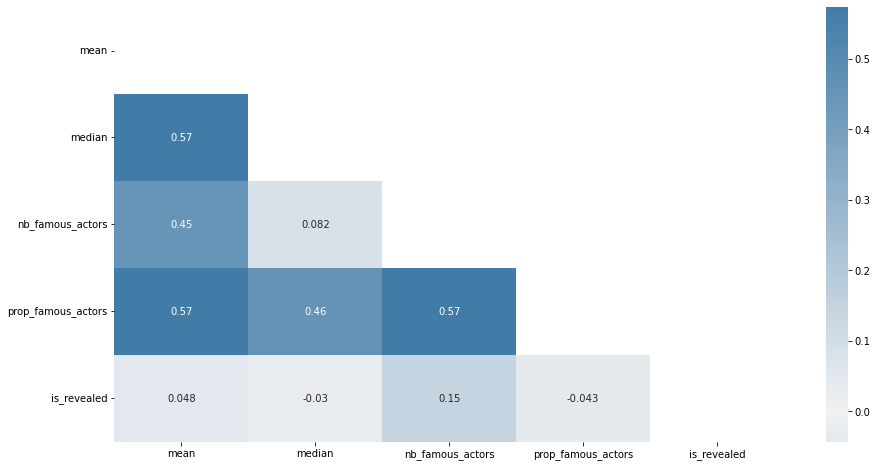

In [1370]:
columns = ['wikipedia_m_ID', 'actor_name', 'mean', 'median', 'nb_famous_actors', 'prop_famous_actors', 'is_revealed']
dataset = df_one_known_unique[columns].groupby(['wikipedia_m_ID', 'actor_name']).mean()

# Heatmap of the correlation between the attributes
corr = dataset.corr()
mask = np.triu(np.ones_like(corr, dtype='bool'))

plt.figure(figsize=(15, 8))
cmap = sns.diverging_palette(240,240, as_cmap=True)
sns.heatmap(data=corr, cmap=cmap, center=0, mask=mask, annot=True)
plt.show()

In [1386]:
X = dataset.drop('is_revealed', axis=1)
y = dataset['is_revealed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Dictionary to store the results
logistic_regression_results = dict()

# Build and fit classifier to training data
clf = LogisticRegression(max_iter=10000, C=0.5, class_weight='balanced')
clf.fit(X_train, y_train)

# Training set accuracy
y_pred = clf.predict(X_train)
acc_tr = accuracy_score(y_pred, y_train) * 100
print("Accuracy on the training data: {:.2f}%".format(acc_tr))

Accuracy on the training data: 63.53%


In [1387]:
# Predict the binary output with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict")
# Compute the False Positive Rate and True Positive Rate
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.68      0.89      0.77      1557
         1.0       0.60      0.29      0.40       929

    accuracy                           0.66      2486
   macro avg       0.64      0.59      0.58      2486
weighted avg       0.65      0.66      0.63      2486



In [1388]:
# Creation of confusion matrix
cm = confusion_matrix(y_test, y_pred)
conf_matrix=pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
logistic_regression_results.update({'cm': conf_matrix})

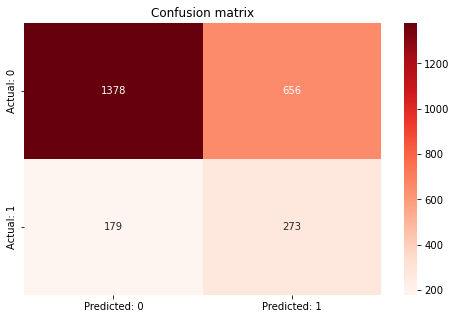

In [1389]:
# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap = 'Reds')
plt.title("Confusion matrix")
plt.show()

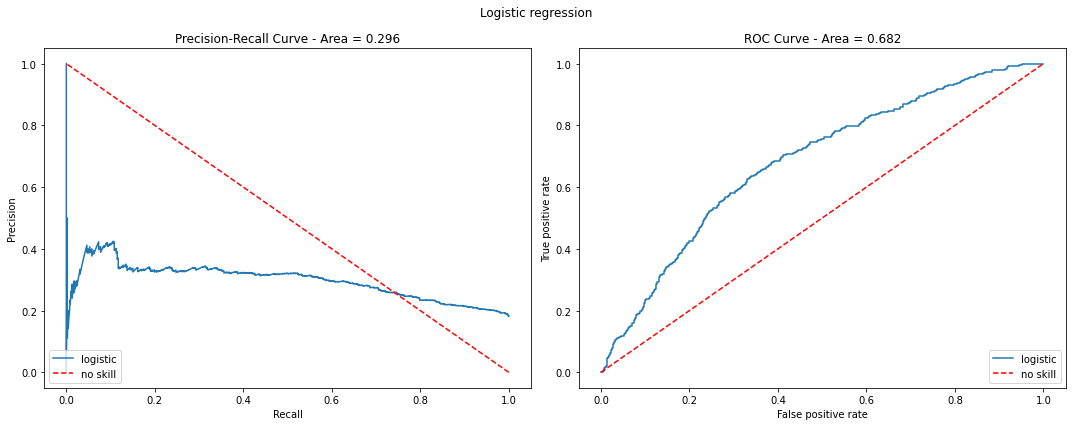

In [1374]:
# Predict the probabilities with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict_proba")

#Compute the precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred[:, 1])

#Compute the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])

# Compute the area under the P-R curve and ROC curve
pr_score = auc(recall, precision)
roc_score = auc(fpr, tpr)

# Plot P-R curve and ROC curve
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

ax = axs[0]
ax.plot(recall, precision, label='logistic')
ax.plot([1, 0], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve - Area = {:.3f}".format(pr_score))
ax.legend(loc = 'lower left')

ax = axs[1]
ax.plot(fpr, tpr, label='logistic')
ax.plot([0, 1], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC Curve - Area = {:.3f}".format(roc_score))
ax.legend(loc = 'lower right')

fig.suptitle('Logistic regression')
fig.tight_layout()
plt.show()

In [829]:
filter_conditions = (
    (df_final["min_year"] != 1980) &
    (df_final["min_year"] <= df_final["m_release_date"].dt.year)
)

df_final = df_final.loc[
    filter_conditions,
].copy(deep=True)

In [798]:
df_final = df_final[df_final.duplicated('wikipedia_m_ID', keep=False)].copy()

In [ ]:
df_final[df_final.duplicated(['actor_name'], keep=False)].copy()

In [800]:
df_final[df_final['already_revealed'] == 0]

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,min_year,min_year_score,nb_actors,movie_score_sum,movie_score_min,movie_score_max,movie_score_mean,movie_score_weighted_mean,is_revealed,already_revealed
19,12053509,/m/02vn81r,1989-04-28,Dr. Joyce Palmer,1951-01-12,F,1.710,NaN,Kirstie Alley,38.0,...,1989,97.0,14,64.0,0.0,64.0,16.000000,4.571429,1,0
142,27918049,/m/0ch2k69,2011-09-09,Det. Pam Stall,1977-03-24,F,1.630,NaN,Jessica Chastain,34.0,...,2011,4.0,16,257.0,0.0,187.0,64.250000,16.062500,1,0
149,24207129,/m/07l50_1,2009-09-11,Jim,1978-04-03,M,1.867,English people,Matthew Goode,31.0,...,2009,70.0,14,120.0,0.0,120.0,20.000000,8.571429,1,0
150,24207129,/m/07l50_1,2009-09-11,Mrs. Strunk,1978-05-22,F,1.680,NaN,Ginnifer Goodwin,31.0,...,2009,66.0,14,120.0,0.0,120.0,20.000000,8.571429,1,0
169,3184269,/m/0dnqr,1989-05-24,"Henry Jones, Sr.",1930-08-25,M,1.890,Scottish people,Sean Connery,58.0,...,1989,99.0,16,311.0,0.0,179.0,44.428571,19.437500,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34964,4443534,/m/0c2pz3,2007-11-16,Henry Edwards,1969-01-14,M,1.800,NaN,Jason Bateman,38.0,...,2007,26.0,10,313.0,0.0,192.0,104.333333,31.300000,1,0
34979,3759215,/m/09zf_q,2002-03-04,Mara,1983-01-18,F,1.702,NaN,Samantha Mumba,19.0,...,2002,55.0,10,149.0,0.0,104.0,29.800000,14.900000,1,0
35013,31422455,/m/0dkc35r,2011-11-04,Neil Patrick Harris,1973-06-15,M,1.850,white people,Neil Patrick Harris,38.0,...,2011,11.0,15,147.0,0.0,120.0,24.500000,9.800000,1,0
35020,11803775,/m/02rt23v,1990-02-23,Sam,1950-03-18,M,1.750,NaN,Brad Dourif,39.0,...,1990,12.0,8,0.0,0.0,0.0,0.000000,0.000000,1,0


<AxesSubplot:>

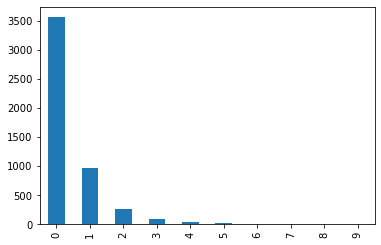

In [801]:
columns = ['wikipedia_m_ID', 'm_release_date', 'movie_score_sum', 'movie_score_min', 'movie_score_max', 'movie_score_mean', 'movie_score_weighted_mean', 'is_revealed']
df_final[columns].groupby(['wikipedia_m_ID'])['is_revealed'].sum().value_counts().plot(kind='bar')

<AxesSubplot:xlabel='index', ylabel='already_revealed'>

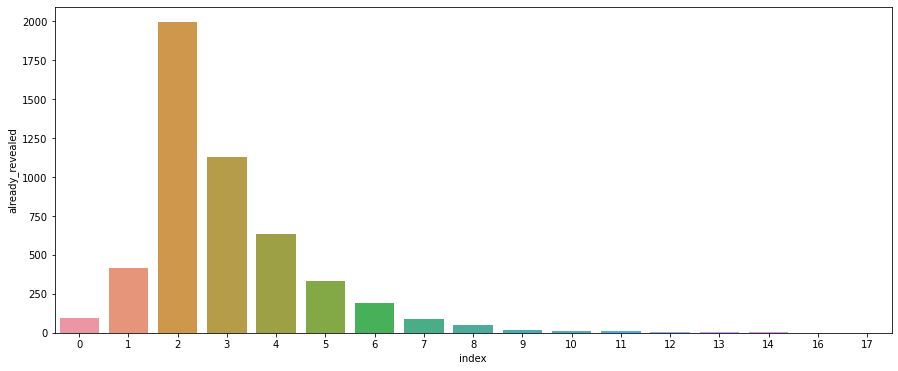

In [802]:
columns = ['wikipedia_m_ID', 'm_release_date', 'movie_score_sum', 'movie_score_min', 'movie_score_max', 'movie_score_mean', 'movie_score_weighted_mean', 'already_revealed']
plt.figure(figsize=(15, 6))
new_df_plot = df_final[columns].groupby(['wikipedia_m_ID'])['already_revealed'].sum().value_counts().reset_index().sort_values('index')
sns.barplot(data=new_df_plot, x='index', y='already_revealed')

In [803]:
columns = ['wikipedia_m_ID', 'actor_name', 'm_release_date', 'movie_score_sum', 'movie_score_min', 'movie_score_max', 'movie_score_mean', 'movie_score_weighted_mean', 'is_revealed', 'already_revealed', 'nb_actors']
df_grouped = (df_final[columns].groupby(['wikipedia_m_ID', 'actor_name']).sum()).copy()

In [804]:
nb_movies_already_revealed = df_grouped.groupby('wikipedia_m_ID')['already_revealed'].sum()

In [805]:
df_grouped.reset_index(inplace=True)

In [806]:
df_grouped['nb_already_revealed'] = df_grouped['wikipedia_m_ID'].apply(lambda x: nb_movies_already_revealed[x])
df_grouped['pro_actors_already_revealed'] = df_grouped.apply(lambda row: row['nb_already_revealed'] / row['nb_actors'], axis=1)

In [807]:
df_grouped.groupby('is_revealed').mean()

,wikipedia_m_ID,movie_score_sum,movie_score_min,movie_score_max,movie_score_mean,movie_score_weighted_mean,already_revealed,nb_actors,nb_already_revealed,pro_actors_already_revealed
is_revealed,,,,,,,,,,
0,1.028418e+07,208.812555,1.582355,113.653410,33.869482,14.149363,1.0,15.189074,3.916050,0.280638
1,7.822183e+06,170.276416,0.000000,104.524298,24.497519,10.948597,0.0,15.883638,2.554169,0.163574


# 2.3 Training

In [808]:
df_grouped.set_index(['wikipedia_m_ID', 'actor_name'], inplace=True)

In [809]:
df_test = df_grouped
df_test = df_grouped.drop_duplicates(keep='first')

<AxesSubplot:>

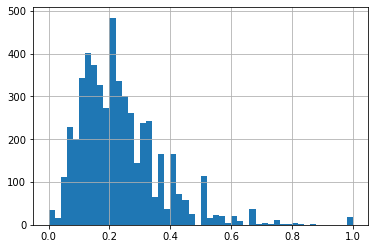

In [810]:
df_test['pro_actors_already_revealed'].hist(bins=50)

In [811]:
df_test.groupby('is_revealed').mean()

,movie_score_sum,movie_score_min,movie_score_max,movie_score_mean,movie_score_weighted_mean,already_revealed,nb_actors,nb_already_revealed,pro_actors_already_revealed
is_revealed,,,,,,,,,
0,193.264647,2.523035,120.632198,38.372011,14.637009,1.0,14.471958,3.210315,0.247005
1,202.134822,0.000000,126.004136,32.344372,13.527802,0.0,15.832920,2.919768,0.193267


In [812]:
X = df_test.drop(['is_revealed', 'already_revealed', 'nb_actors', 'nb_already_revealed', 'pro_actors_already_revealed'], axis=1).values
y = df_test['is_revealed']

In [813]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [814]:
# Dictionary to store the results
logistic_regression_results = dict()

# Build and fit classifier to training data
clf = LogisticRegression(solver='liblinear', max_iter=10000, C=2, class_weight='balanced')
clf.fit(X_train, y_train)

LogisticRegression(C=2, class_weight='balanced', max_iter=10000,
                   solver='liblinear')

In [815]:
# Training set accuracy
y_pred = clf.predict(X_train)
acc_tr = accuracy_score(y_pred, y_train) * 100
print("Accuracy on the training data: {:.2f}%".format(acc_tr))

Accuracy on the training data: 53.19%


In [816]:
# Predict the binary output with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict")
# Compute the False Positive Rate and True Positive Rate
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.48      0.84      0.61       682
           1       0.69      0.28      0.40       879

    accuracy                           0.53      1561
   macro avg       0.58      0.56      0.50      1561
weighted avg       0.60      0.53      0.49      1561



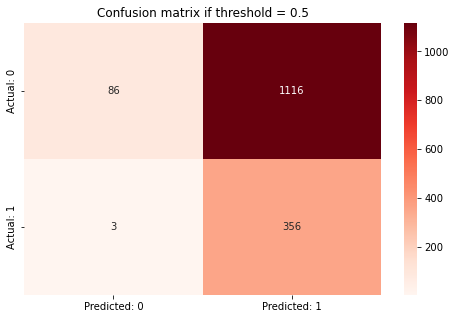

In [827]:
# Creation of confusion matrix
cm = confusion_matrix(y_test, (y_pred[:,1]>=0.3).astype(int))
conf_matrix=pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
logistic_regression_results.update({'cm': conf_matrix})

# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap = 'Reds')
plt.title("Confusion matrix if threshold = 0.5")
plt.show()

In [817]:
# Predict the probabilities with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict_proba")

#Compute the precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred[:, 1])

#Compute the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])

# Compute the area under the P-R curve and ROC curve
pr_score = auc(recall, precision)
roc_score = auc(fpr, tpr)

logistic_regression_results.update({'precision': precision})
logistic_regression_results.update({'recall': recall})
logistic_regression_results.update({'pr_score': pr_score})
logistic_regression_results.update({'fpr': fpr})
logistic_regression_results.update({'tpr': tpr})
logistic_regression_results.update({'roc_score': roc_score})

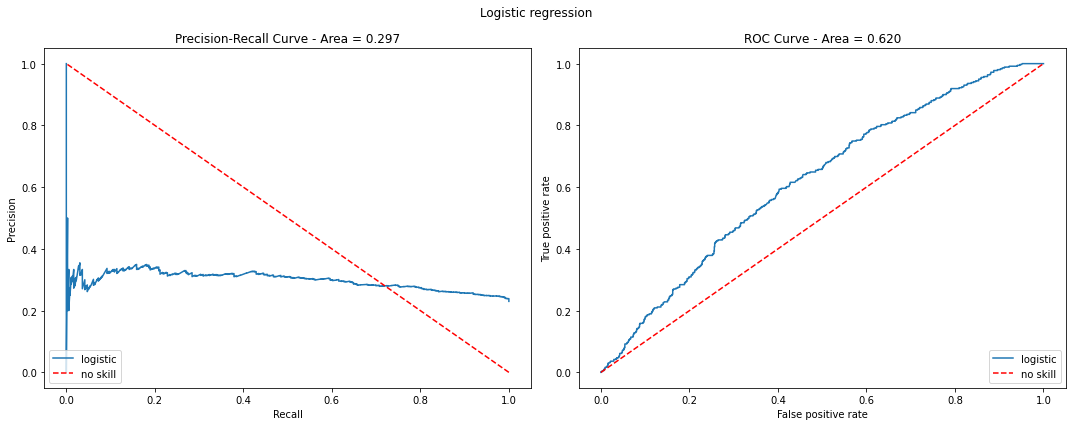

In [818]:
# Plot P-R curve and ROC curve
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

ax = axs[0]
ax.plot(recall, precision, label='logistic')
ax.plot([1, 0], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve - Area = {:.3f}".format(pr_score))
ax.legend(loc = 'lower left')

ax = axs[1]
ax.plot(fpr, tpr, label='logistic')
ax.plot([0, 1], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC Curve - Area = {:.3f}".format(roc_score))
ax.legend(loc = 'lower right')

fig.suptitle('Logistic regression')
fig.tight_layout()
plt.show()

# 3.1 One hot

In [92]:
df_chars_numbers = df_chars.merge(df_numbers, left_on='actor_name', right_index=True)
df_chars_numbers.head()

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,2015,2016,2017,2018,2019,2020,2021,2022,mean_score,is_na
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,40
5314,9340076,/m/02854l1,1996-01-01,Delon,1974-08-15,F,1.78,NaN,Natasha Henstridge,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,40
78973,1026994,/m/03_gr5,2004-04-09,Cynthia,1974-08-15,F,1.78,NaN,Natasha Henstridge,29.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,40
88573,704406,/m/0346m0,1998-04-10,Eve,1974-08-15,F,1.78,NaN,Natasha Henstridge,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,40
133603,7903848,/m/026jg5c,2005-01-01,NaN,1974-08-15,F,1.78,NaN,Natasha Henstridge,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,40


In [93]:
#checkez les 600 restant·e·s
df_chars_numbers['actor_name'].nunique()

2110

In [12]:
df_chars_numbers['wikipedia_m_ID'].count()

47938

In [95]:
df_chars_numbers.drop_duplicates(subset=['wikipedia_m_ID', 'actor_name'], keep='first', inplace=True)

In [96]:
df_chars_numbers.head()

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,2015,2016,2017,2018,2019,2020,2021,2022,mean_score,is_na
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,40
5314,9340076,/m/02854l1,1996-01-01,Delon,1974-08-15,F,1.78,NaN,Natasha Henstridge,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,40
78973,1026994,/m/03_gr5,2004-04-09,Cynthia,1974-08-15,F,1.78,NaN,Natasha Henstridge,29.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,40
88573,704406,/m/0346m0,1998-04-10,Eve,1974-08-15,F,1.78,NaN,Natasha Henstridge,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,40
133603,7903848,/m/026jg5c,2005-01-01,NaN,1974-08-15,F,1.78,NaN,Natasha Henstridge,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,40


In [97]:
def get_min_year_score(row):
    for x in df_numbers.columns[:-2]:
        if row[x] >0:
            return float(row[x])

In [98]:
def get_min_year(row):
    for x in df_numbers.columns[:-2]:
        if row[x] >0:
            return int(x)

In [99]:
#df_chars_numbers['min_year'] 
df_chars_numbers['min_year'] = df_chars_numbers.apply(lambda row: get_min_year(row), axis=1)
df_chars_numbers['min_year_score'] = df_chars_numbers.apply(lambda row: get_min_year_score(row), axis=1)

In [18]:
df_chars_numbers.head()

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,2017,2018,2019,2020,2021,2022,mean_score,is_na,min_year,min_year_score
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,57.0,40,2000,57.0
5314,9340076,/m/02854l1,1996-01-01,Delon,1974-08-15,F,1.78,NaN,Natasha Henstridge,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,57.0,40,2000,57.0
78973,1026994,/m/03_gr5,2004-04-09,Cynthia,1974-08-15,F,1.78,NaN,Natasha Henstridge,29.0,...,NaN,NaN,NaN,NaN,NaN,NaN,57.0,40,2000,57.0
88573,704406,/m/0346m0,1998-04-10,Eve,1974-08-15,F,1.78,NaN,Natasha Henstridge,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,57.0,40,2000,57.0
133603,7903848,/m/026jg5c,2005-01-01,NaN,1974-08-15,F,1.78,NaN,Natasha Henstridge,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,57.0,40,2000,57.0


In [866]:
df_chars_numbers.head(10)

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,2019,2020,2021,2022,mean_score,is_na,movie_actor_score,min_year,min_year_score,nb_movies_at_release_date
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,...,NaN,NaN,NaN,NaN,57.0,40,57.0,2000,57.0,8
5314,9340076,/m/02854l1,1996-01-01,Delon,1974-08-15,F,1.78,NaN,Natasha Henstridge,21.0,...,NaN,NaN,NaN,NaN,57.0,40,0.0,2000,57.0,1
78973,1026994,/m/03_gr5,2004-04-09,Cynthia,1974-08-15,F,1.78,NaN,Natasha Henstridge,29.0,...,NaN,NaN,NaN,NaN,57.0,40,0.0,2000,57.0,11
88573,704406,/m/0346m0,1998-04-10,Eve,1974-08-15,F,1.78,NaN,Natasha Henstridge,23.0,...,NaN,NaN,NaN,NaN,57.0,40,0.0,2000,57.0,3
133603,7903848,/m/026jg5c,2005-01-01,NaN,1974-08-15,F,1.78,NaN,Natasha Henstridge,30.0,...,NaN,NaN,NaN,NaN,57.0,40,0.0,2000,57.0,13
134289,2216783,/m/06wp5n,2000-11-15,Mimi Prager,1974-08-15,F,1.78,NaN,Natasha Henstridge,26.0,...,NaN,NaN,NaN,NaN,57.0,40,0.0,2000,57.0,5
137932,2999460,/m/08jpy6,2000-05-07,Hypsipyle,1974-08-15,F,1.78,NaN,Natasha Henstridge,25.0,...,NaN,NaN,NaN,NaN,57.0,40,0.0,2000,57.0,5
178049,6446995,/m/0g5qvj,2000-02-18,Cynthia Tudeski,1974-08-15,F,1.78,NaN,Natasha Henstridge,25.0,...,NaN,NaN,NaN,NaN,57.0,40,0.0,2000,57.0,5
199186,4481841,/m/0c4wrz,2004-11-27,Eve,1974-08-15,F,1.78,NaN,Natasha Henstridge,30.0,...,NaN,NaN,NaN,NaN,57.0,40,0.0,2000,57.0,11
200576,15447596,/m/03m9n5w,2008-01-01,NaN,1974-08-15,F,1.78,NaN,Natasha Henstridge,33.0,...,NaN,NaN,NaN,NaN,57.0,40,0.0,2000,57.0,15


In [100]:
df_chars_test = df_chars_numbers.copy()
df_chars_test.head()

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,2017,2018,2019,2020,2021,2022,mean_score,is_na,min_year,min_year_score
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,57.0,40,2000,57.0
5314,9340076,/m/02854l1,1996-01-01,Delon,1974-08-15,F,1.78,NaN,Natasha Henstridge,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,57.0,40,2000,57.0
78973,1026994,/m/03_gr5,2004-04-09,Cynthia,1974-08-15,F,1.78,NaN,Natasha Henstridge,29.0,...,NaN,NaN,NaN,NaN,NaN,NaN,57.0,40,2000,57.0
88573,704406,/m/0346m0,1998-04-10,Eve,1974-08-15,F,1.78,NaN,Natasha Henstridge,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,57.0,40,2000,57.0
133603,7903848,/m/026jg5c,2005-01-01,NaN,1974-08-15,F,1.78,NaN,Natasha Henstridge,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,57.0,40,2000,57.0


In [134]:
# 1.7 (second way of doing it)
df_final = df_chars_test.merge(df_chars_test, on=['wikipedia_m_ID', 'freebase_m_ID', 'm_release_date'], how='left')

In [135]:
df_final.head()

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name_x,actor_dob_x,actor_gender_x,actor_height_x,actor_ethnicity_x,actor_name_x,actor_age_x,...,2017_y,2018_y,2019_y,2020_y,2021_y,2022_y,mean_score_y,is_na_y,min_year_y,min_year_score_y
0,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,57.000000,40,2000,57.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,...,129.0,129.0,24.0,NaN,NaN,NaN,101.760000,18,1991,78.0
2,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,...,163.0,168.0,256.0,167.0,147.0,59.0,93.565217,20,2000,19.0
3,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,46.000000,40,1997,46.0
4,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,51.000000,40,1991,51.0


In [136]:
filter_conditions = (
    (df_final["actor_name_x"] != df_final["actor_name_y"]) &
    (df_final["min_year_x"] > 1980) &
    (df_final["min_year_x"] > df_final["min_year_y"]) &
    (df_final["min_year_x"] == df_final["m_release_date"].dt.year)
)

df_final = df_final.loc[
    filter_conditions,
].copy(deep=True)

In [137]:
df_final[df_final['actor_name_x'] == 'Zac Efron'][['wikipedia_m_ID', 'freebase_m_ID', 'm_release_date', 'character_name_x','actor_dob_x', 'actor_gender_x', 'actor_height_x', 'actor_ethnicity_x','actor_name_x', 'actor_age_x','actor_name_y', 'min_year_x', 'min_year_y']]
#df_final[df_final['actor_name_x'] == 'Natasha Henstridge']

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name_x,actor_dob_x,actor_gender_x,actor_height_x,actor_ethnicity_x,actor_name_x,actor_age_x,actor_name_y,min_year_x,min_year_y


In [138]:
df_final['actor_name_y'].value_counts()

Ben Stiller          39
Bruce Willis         37
Dennis Quaid         34
John Goodman         33
Samuel L. Jackson    32
                     ..
Briana Evigan         1
Hoyt Axton            1
Vincent Cassel        1
Jami Gertz            1
Aaron Yoo             1
Name: actor_name_y, Length: 1161, dtype: int64

In [23]:
#df_final['diff_year'] = df_final.apply(lambda row: row['m_release_date'].year - row['min_year_x'], axis=1)

In [24]:
df_final

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name_x,actor_dob_x,actor_gender_x,actor_height_x,actor_ethnicity_x,actor_name_x,actor_age_x,...,2017_y,2018_y,2019_y,2020_y,2021_y,2022_y,mean_score_y,is_na_y,min_year_y,min_year_score_y
18,2216783,/m/06wp5n,2000-11-15,Mimi Prager,1974-08-15,F,1.78,NaN,Natasha Henstridge,26.0,...,NaN,NaN,100.0,100.0,100.0,NaN,128.700000,23,1998,153.0
19,2216783,/m/06wp5n,2000-11-15,Mimi Prager,1974-08-15,F,1.78,NaN,Natasha Henstridge,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,91.000000,40,1987,91.0
21,2216783,/m/06wp5n,2000-11-15,Mimi Prager,1974-08-15,F,1.78,NaN,Natasha Henstridge,26.0,...,249.0,249.0,91.0,77.0,115.0,115.0,161.923077,17,1997,94.0
23,2999460,/m/08jpy6,2000-05-07,Hypsipyle,1974-08-15,F,1.78,NaN,Natasha Henstridge,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,40,1993,5.0
24,2999460,/m/08jpy6,2000-05-07,Hypsipyle,1974-08-15,F,1.78,NaN,Natasha Henstridge,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,67.000000,41,1980,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210797,101813,/m/0ptdz,2000-12-12,Josh Campbell,NaN,M,NaN,NaN,Ryan Milkovich,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,58.000000,42,1980,58.0
210802,34025292,/m/0gwxf3x,2012-04-27,Doug,1980-07-03,M,1.57,African Americans,Kevin Hart,31.0,...,NaN,NaN,NaN,NaN,64.0,64.0,52.000000,38,2000,44.0
210805,34025292,/m/0gwxf3x,2012-04-27,Doug,1980-07-03,M,1.57,African Americans,Kevin Hart,31.0,...,133.0,261.0,168.0,168.0,181.0,181.0,135.846154,30,2010,48.0
210806,34025292,/m/0gwxf3x,2012-04-27,Doug,1980-07-03,M,1.57,African Americans,Kevin Hart,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,55.125000,35,2009,54.0


In [25]:
columns = ['wikipedia_m_ID', 'm_release_date','actor_dob_x', 'actor_gender_x', 'actor_height_x',
           'actor_name_x', 'actor_age_x', 'mean_score_x','min_year_x', 'actor_dob_y', 'actor_gender_y', 'actor_height_y',
          'actor_name_y', 'actor_age_y','1980_y', '1981_y', '1982_y', '1983_y', '1984_y', '1985_y', '1986_y', '1987_y',
       '1988_y', '1989_y', '1990_y', '1991_y', '1992_y', '1993_y', '1994_y', '1995_y', '1996_y', '1997_y',
       '1998_y', '1999_y', '2000_y', '2001_y', '2002_y', '2003_y', '2004_y', '2005_y', '2006_y', '2007_y',
       '2008_y', '2009_y', '2010_y', '2011_y', '2012_y', '2013_y', '2014_y',
       '2015_y', '2016_y', '2017_y', '2018_y', '2019_y', '2020_y', '2021_y', '2022_y', 'mean_score_y','min_year_y']

In [116]:
df_test = pd.get_dummies(df_final, columns=['actor_name_y'], prefix='').copy()
df_test.head()

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name_x,actor_dob_x,actor_gender_x,actor_height_x,actor_ethnicity_x,actor_name_x,actor_age_x,...,_Zachary Levi,_Zachary Mabry,_Zachary Quinto,_Zelda Harris,_Zhang Ziyi,_Zhou Xun,_Zoe Kazan,_Zoe Saldana,_Zooey Deschanel,_Zoë Kravitz
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,...,0,0,0,0,0,0,0,0,0,0
2,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,...,0,0,0,0,0,0,0,0,0,0
3,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,...,0,0,0,0,0,0,0,0,0,0
4,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,...,0,0,0,0,0,0,0,0,0,0
8,1026994,/m/03_gr5,2004-04-09,Cynthia,1974-08-15,F,1.78,NaN,Natasha Henstridge,29.0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
df_final[df_final['actor_name_x']=='Harry J. Lennix'][['actor_name_x', 'actor_name_y', 'm_release_date', 'min_year_x', 'min_year_y']]

,actor_name_x,actor_name_y,m_release_date,min_year_x,min_year_y
134355,Harry J. Lennix,Ben Kingsley,2004-08-27,2004,1982
134357,Harry J. Lennix,Aaron Eckhart,2004-08-27,2004,2003
134358,Harry J. Lennix,Terrence Howard,2004-09-12,2004,2008
134359,Harry J. Lennix,Jamie Foxx,2004-09-12,2004,1999
134360,Harry J. Lennix,Bokeem Woodbine,2004-09-12,2004,1998
134361,Harry J. Lennix,Kerry Washington,2004-09-12,2004,2008
134362,Harry J. Lennix,Aunjanue Ellis,2004-09-12,2004,2002
134364,Harry J. Lennix,Warwick Davis,2004-09-12,2004,1988
134365,Harry J. Lennix,Bernie Mac,1992-07-24,2004,1998
134366,Harry J. Lennix,Damon Wayans,1992-07-24,2004,1991


In [59]:
columns = [col for col in df_test if col.startswith('_')]

In [52]:
def change_actor_one_hot_weight(row, actor):
    if row[actor] != 1:
        return row[actor]
    else:
        release_date = row['m_release_date'].year
        weight = 0
        career = range(row['min_year_y'], release_date)
        for x in career:
            if row[str(x)+'_y']:
                weight+=row[str(x)+'_y']
        weight = weight/len(career)
        return weight

In [53]:
import time
for actor in columns:
    df_test[actor] = df_test.apply(lambda row: change_actor_one_hot_weight(row, actor), axis=1)

In [54]:
df_test

,index,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name_x,actor_dob_x,actor_gender_x,actor_height_x,actor_ethnicity_x,actor_name_x,...,_Woody Allen,_Woody Harrelson,_Zac Efron,_Zach Braff,_Zach Galifianakis,_Zachary Gordon,_Zachary Quinto,_Zhang Ziyi,_Zoe Saldana,_Zooey Deschanel
0,18,2216783,/m/06wp5n,2000-11-15,Mimi Prager,1974-08-15,F,1.78,NaN,Natasha Henstridge,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,19,2216783,/m/06wp5n,2000-11-15,Mimi Prager,1974-08-15,F,1.78,NaN,Natasha Henstridge,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21,2216783,/m/06wp5n,2000-11-15,Mimi Prager,1974-08-15,F,1.78,NaN,Natasha Henstridge,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,23,2999460,/m/08jpy6,2000-05-07,Hypsipyle,1974-08-15,F,1.78,NaN,Natasha Henstridge,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24,2999460,/m/08jpy6,2000-05-07,Hypsipyle,1974-08-15,F,1.78,NaN,Natasha Henstridge,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7065,210797,101813,/m/0ptdz,2000-12-12,Josh Campbell,NaN,M,NaN,NaN,Ryan Milkovich,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7066,210802,34025292,/m/0gwxf3x,2012-04-27,Doug,1980-07-03,M,1.57,African Americans,Kevin Hart,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7067,210805,34025292,/m/0gwxf3x,2012-04-27,Doug,1980-07-03,M,1.57,African Americans,Kevin Hart,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7068,210806,34025292,/m/0gwxf3x,2012-04-27,Doug,1980-07-03,M,1.57,African Americans,Kevin Hart,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
columns.append('actor_name_x')
X = df_test[columns].groupby('actor_name_x').sum().copy().values

In [85]:
X.sum(axis=0)

array([  11.,   65., 1877., ...,    0.,  162.,  104.])

In [63]:
X.sum(axis=0).std()

8257.230470395998

In [64]:
y = df_test.drop_duplicates('actor_name_x', keep='first')['min_year_score_x']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

reg = LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_train, y_train)
reg.score(X_test, y_test)

-2.145092887420338e+30

In [72]:
#reg.predict(X_test)